# Экспоненциальное сглаживание временных рядов ожидаемой продолжительности жизни по странам

In [1]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [12]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from utils.constants import (
    F, 
)
from utils.graphics import (
    display_prediction,
    display_corellation_by_target,
)
from utils.prepare_data import (
    get_location_codes,
    get_location_time_series,
    get_location_by_code,
    get_train_test_data,
    get_data_with_smoothing_target_feature,
)

%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [3]:
# Загрузим таблицу
data_source = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

data_source.head()

ParentLocationCode ParentLocation SpatialDimValueCode Location  Period  \
0                AFR         Africa                 AGO   Angola    2000   
1                AFR         Africa                 AGO   Angola    2001   
2                AFR         Africa                 AGO   Angola    2002   
3                AFR         Africa                 AGO   Angola    2003   
4                AFR         Africa                 AGO   Angola    2004   

   AdultMortality  Homicides  MaternalMortality  AdultNcdMortality  \
0           34.56    0.01331           0.859921               30.5   
1           33.86    0.01310           0.799641               29.7   
2           32.51    0.01288           0.758272               29.4   
3           32.16    0.01265           0.676496               29.3   
4           32.24    0.01229           0.594192               29.0   

   AdultNcdMortality117  ...  HealthCareCostsGdp  HealthCareCostsPerCapita  \
0              0.028126  ...                1.11                      7.66   
1              0.027503  ...                2.05                     13.35   
2              0.027049  ...                1.31                     11.54   
3              0.026962  ...                1.47                     14.55   
4              0.026300  ...                1.69                     21.36   

   GdpPerCapita  Population  Schooling  ClusterKMeans  PositiveCoef  \
0    563.733796  16194869.0   5.027188              1      0.839586   
1    533.586202  16747208.0   5.092250              1      0.839586   
2    882.147847  17327699.0   5.157312              1      0.839586   
3    992.698979  17943712.0   5.222375              1      0.839586   
4   1266.210864  18600423.0   5.287437              1      0.839586   

   NegativeCoef  ImmunizationMean  LifeExpectancy  
0      0.837126         28.000000           49.37  
1      0.837126         43.333333           50.06  
2      0.837126         42.666667           51.06  
3      0.837126         37.000000           51.74  
4      0.837126         36.000000           52.36  

[5 rows x 40 columns]

## Создание признака

Поскольку данные об ожидаемой продолжительности жизни являются временным рядом для каждой страны,\
и предсказание имеет смысл делать на будущие года,\
то можно создать новый признак из сглаженных значений предыдущих лет и сглаженного прогноза на будущее.

Для получения прогноза с помощью экспоненциального сглаживания воспользуемся методом [ExponentialSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)
из библиотеки `statsmodels`.

Данные признак не будем помещать в исходную таблицу, но создадим функцию, \
которая будет добавлять его в тренировочные и тестовые данные при необходимости.

Функция `get_data_with_smoothing_target_feature` для создания данного признака \
вынесена в файл [../utils/prepare_data.py](../utils/prepare_data.py) .

В этом же файле находится функция `get_train_test_data` для разделения данных на тренировочные и тестовые.\
Функция учитывает, что мы разделяем выборку для временного ряда и возвращает в качестве \
тестовых данных последние 3 года изначальной выборки.

In [4]:
# Разделим данные на тренировочные и тестовые
train_data_source, test_data_source = get_train_test_data(data_source)

# Добавим столбец SmoothingLifeExpectancy со сглаженными значениями и прогнозом 
# в тренировочные и тестовые данные
train_data, test_data = get_data_with_smoothing_target_feature(
    train_data_source, test_data_source
)

In [5]:
# Проверим, что столбец добавился для тренировочных и тестовых данных
display(train_data.head(3))
display(test_data.head(3))

ParentLocationCode         ParentLocation SpatialDimValueCode     Location  \
0                EMR  Eastern Mediterranean                 AFG  Afghanistan   
1                EMR  Eastern Mediterranean                 AFG  Afghanistan   
2                EMR  Eastern Mediterranean                 AFG  Afghanistan   

   Period  AdultMortality  Homicides  MaternalMortality  AdultNcdMortality  \
0    2000           37.82    0.00978           1.346144               43.2   
1    2001           38.03    0.00964           1.273431               43.5   
2    2002           36.75    0.01018           1.277308               43.1   

   AdultNcdMortality117  ...  HealthCareCostsPerCapita  GdpPerCapita  \
0              0.030243  ...                134.172105    174.930991   
1              0.031152  ...                147.827895    138.706822   
2              0.031022  ...                  0.150000    178.954088   

   Population  Schooling  ClusterKMeans  PositiveCoef  NegativeCoef  \
0  20130327.0      3.030              1      0.814775      0.845913   
1  20284307.0      3.088              1      0.814775      0.845913   
2  21378117.0      3.146              1      0.814775      0.845913   

   ImmunizationMean  LifeExpectancy  SmoothingLifeExpectancy  
0         25.000000           53.82                53.698636  
1         35.000000           53.91                54.494593  
2         35.666667           55.15                54.393540  

[3 rows x 41 columns]

ParentLocationCode         ParentLocation SpatialDimValueCode     Location  \
0                EMR  Eastern Mediterranean                 AFG  Afghanistan   
1                EMR  Eastern Mediterranean                 AFG  Afghanistan   
2                EMR  Eastern Mediterranean                 AFG  Afghanistan   

   Period  AdultMortality  Homicides  MaternalMortality  AdultNcdMortality  \
0    2018           30.80   0.008520           0.663428               34.6   
1    2019           29.38   0.008460           0.644273               34.4   
2    2020           30.82   0.008443           0.620408               34.8   

   AdultNcdMortality117  ...  HealthCareCostsPerCapita  GdpPerCapita  \
0              0.021958  ...                      2.77    491.337221   
1              0.021885  ...                      2.48    496.602504   
2              0.020692  ...                      6.12    510.787063   

   Population  Schooling  ClusterKMeans  PositiveCoef  NegativeCoef  \
0  36743039.0      5.338              1      0.814775      0.845913   
1  37856121.0      5.514              1      0.814775      0.845913   
2  39068979.0      5.690              1      0.814775      0.845913   

   ImmunizationMean  LifeExpectancy  SmoothingLifeExpectancy  
0         68.666667           60.49                61.007708  
1         64.333333           61.22                61.182749  
2         62.333333           60.49                61.338687  

[3 rows x 41 columns]

В конец обеих таблиц добавился новый признак `SmoothingLifeExpectancy` со значениями, близкими к целевой переменной.

## Графики значений признака для отдельных стран

Посмотрим на грфики значений признака для каждой страны.

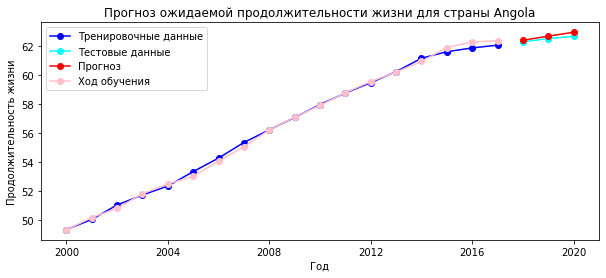

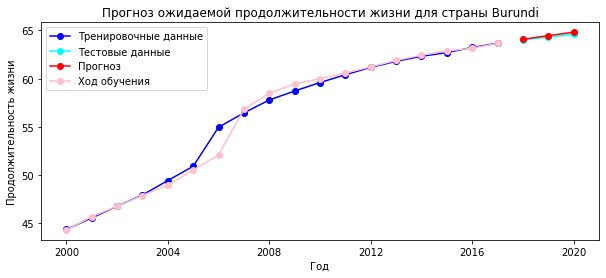

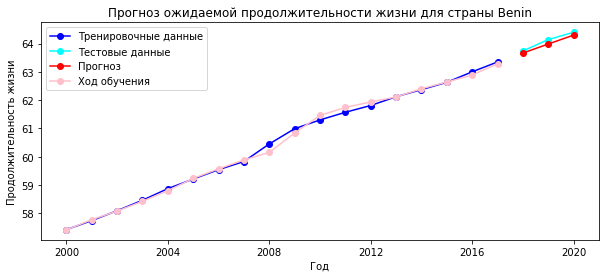

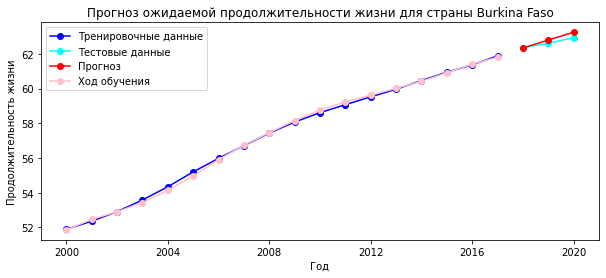

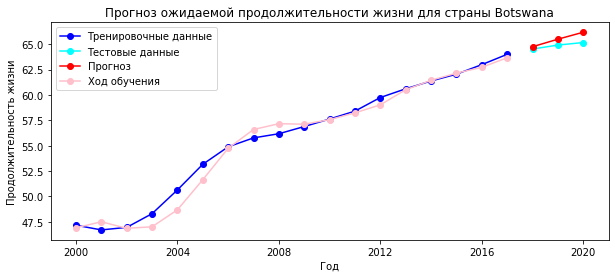

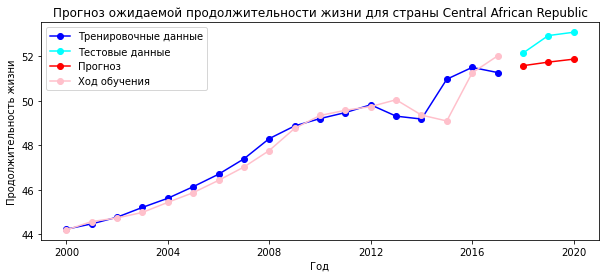

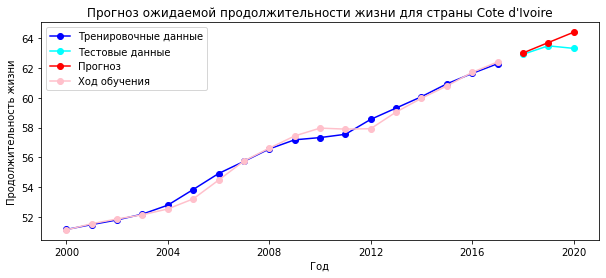

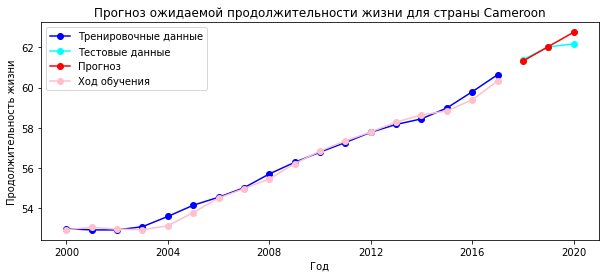

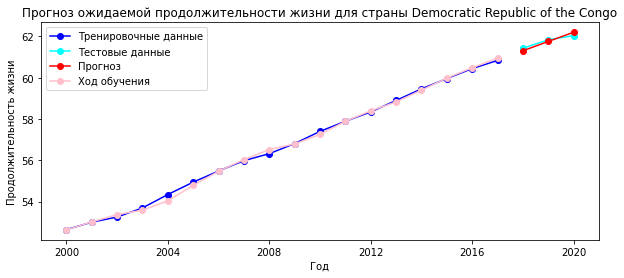

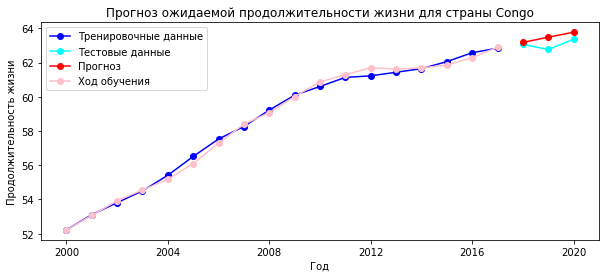

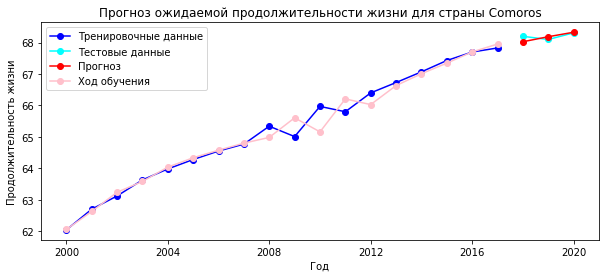

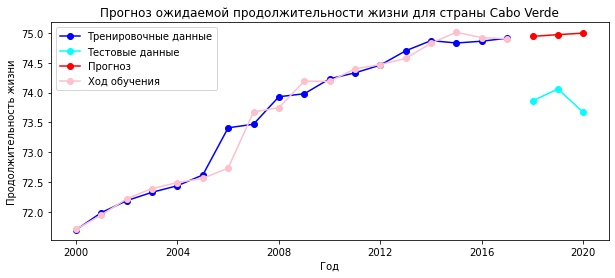

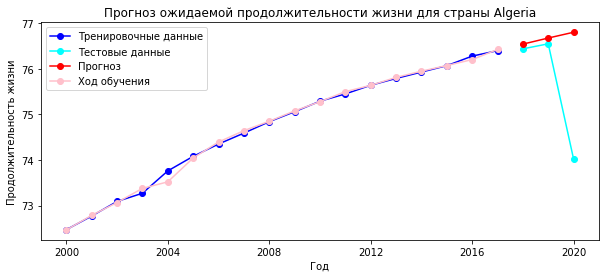

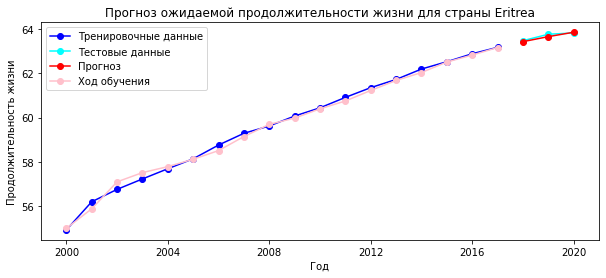

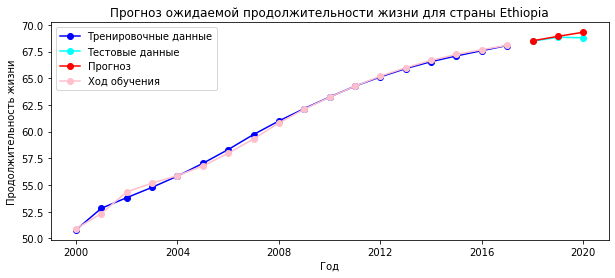

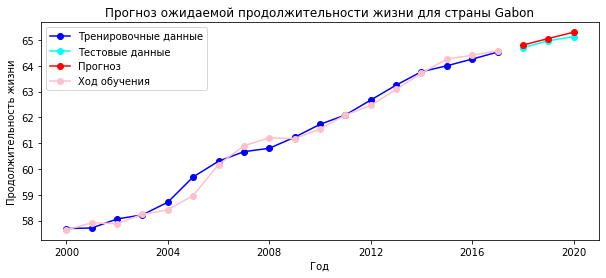

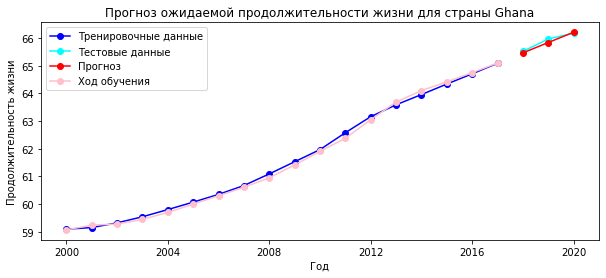

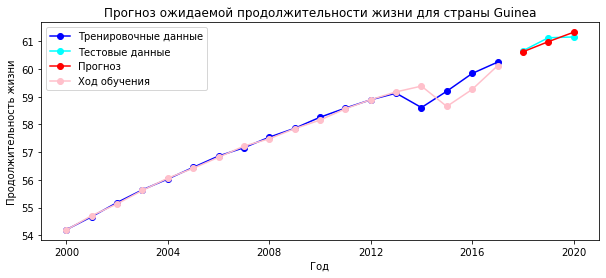

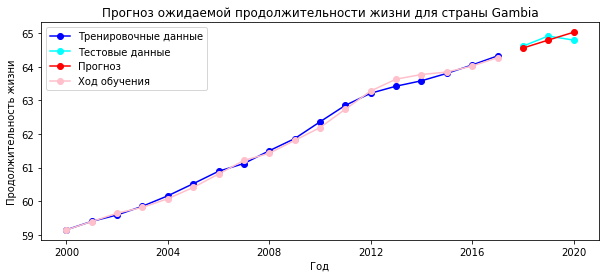

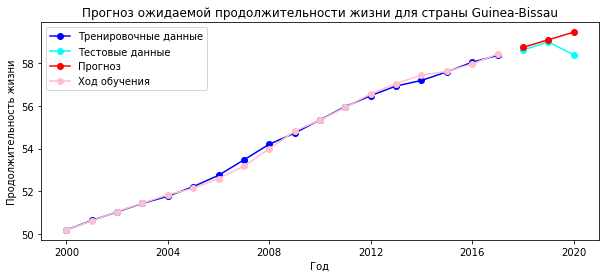

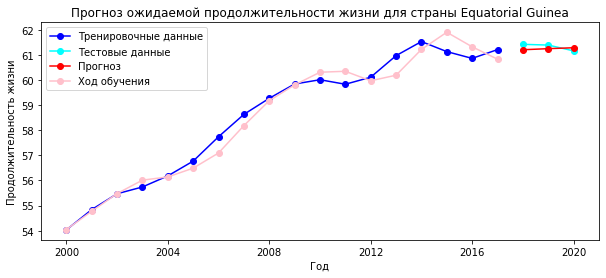

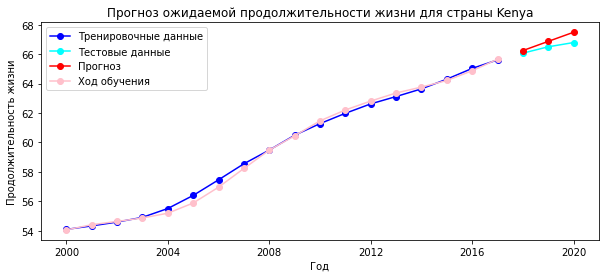

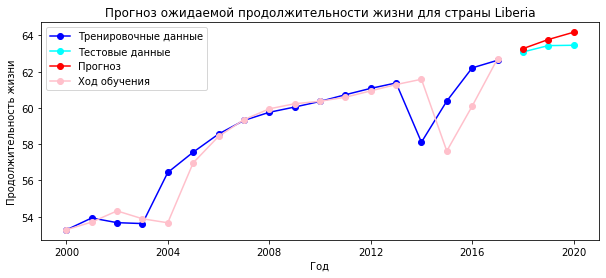

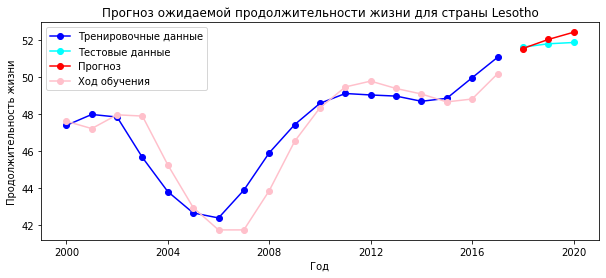

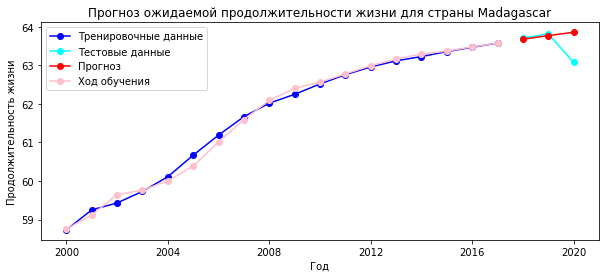

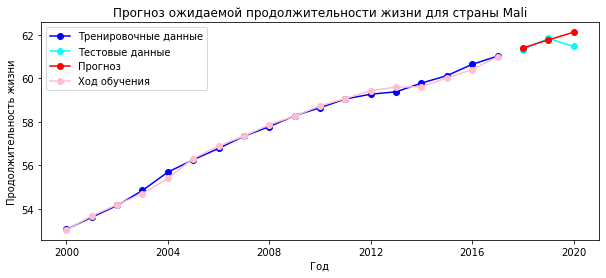

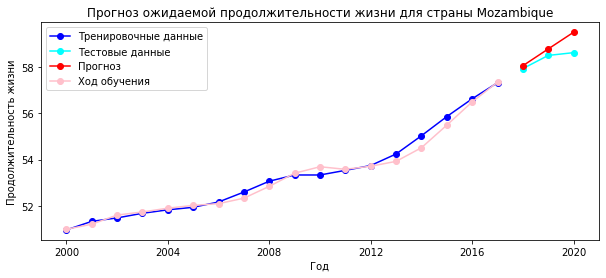

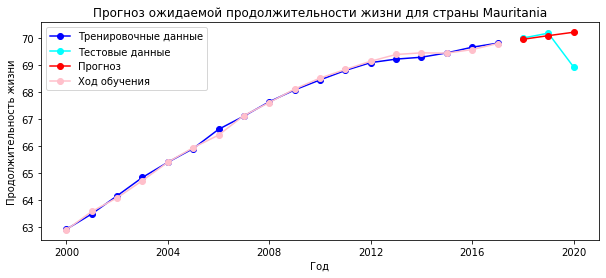

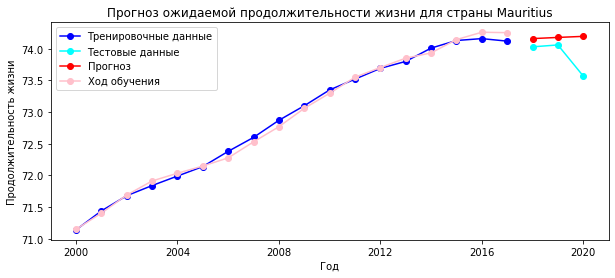

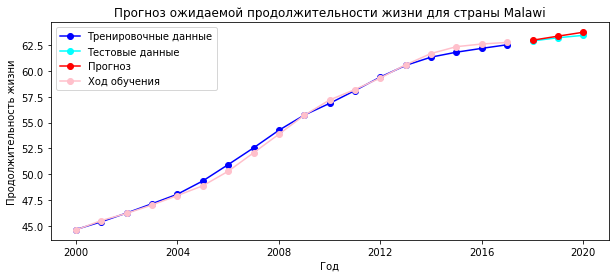

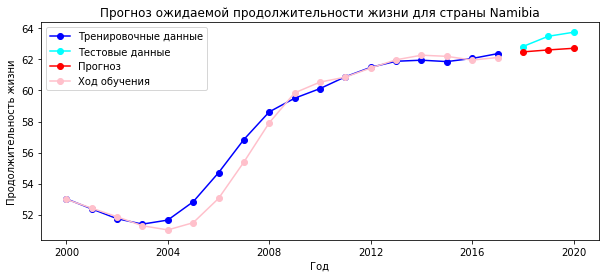

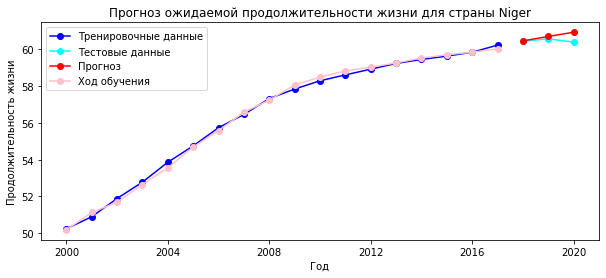

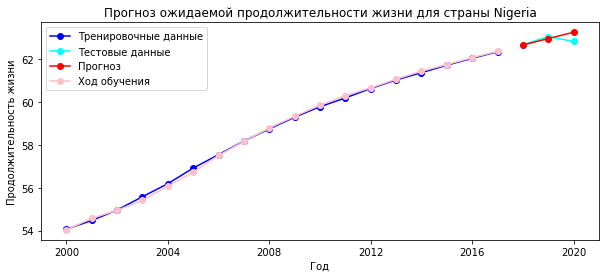

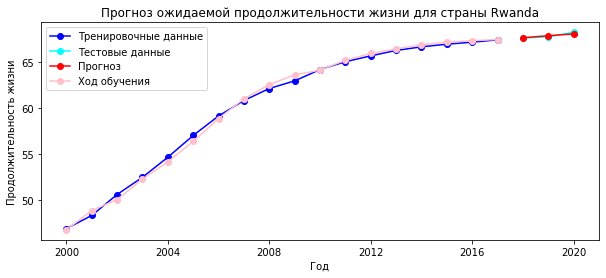

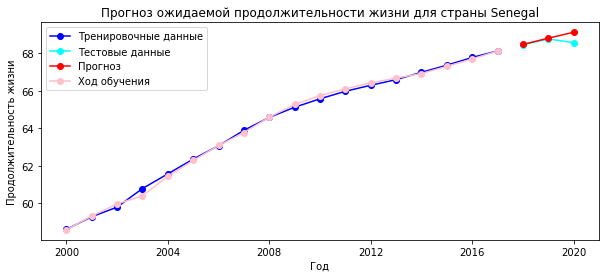

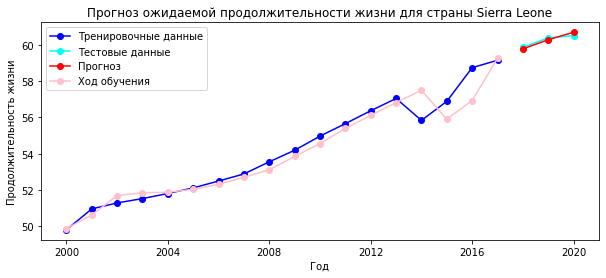

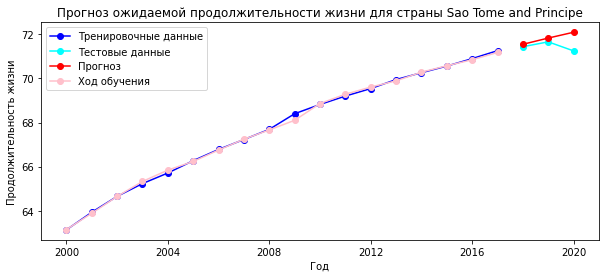

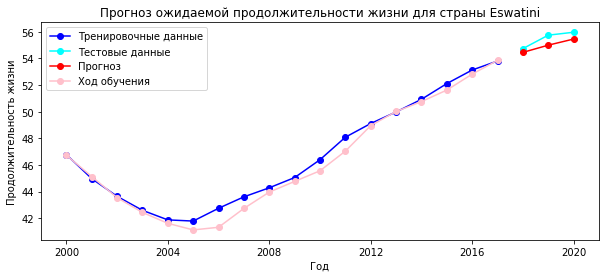

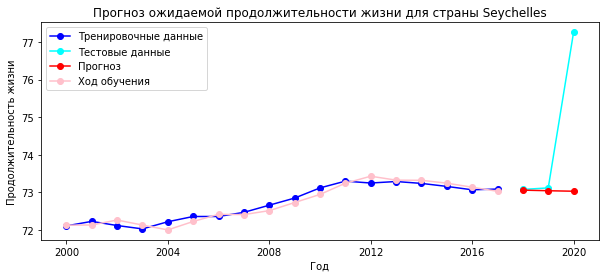

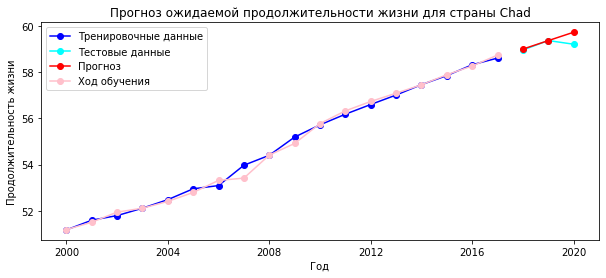

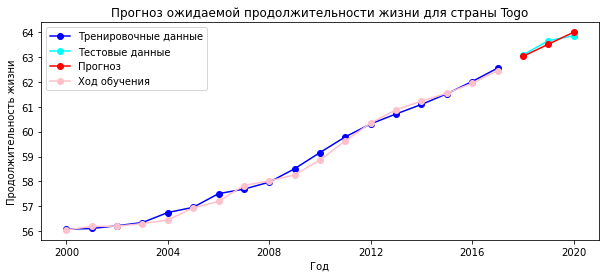

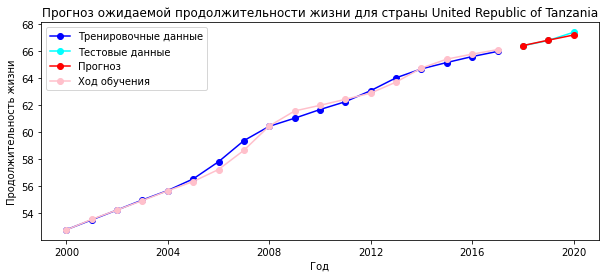

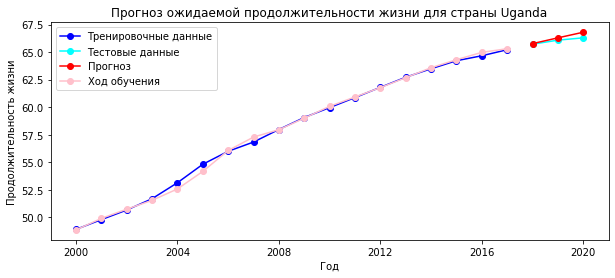

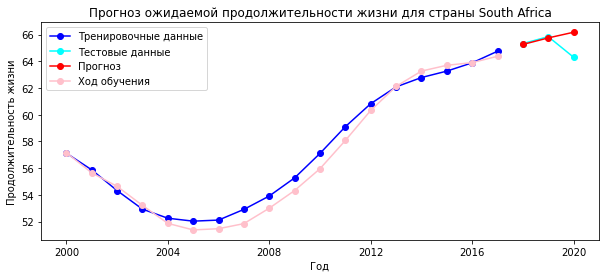

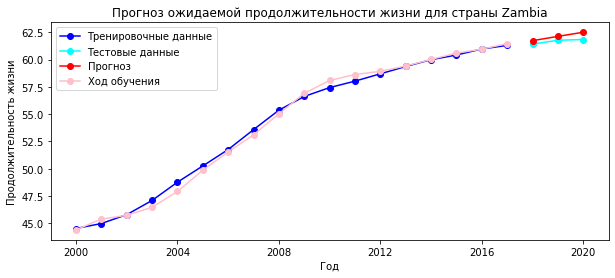

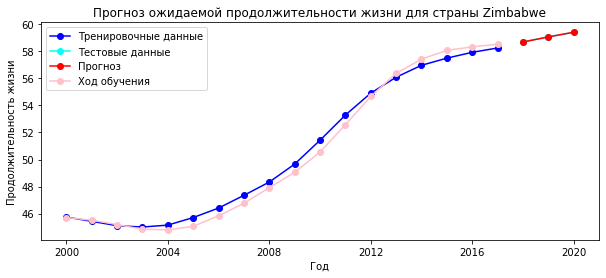

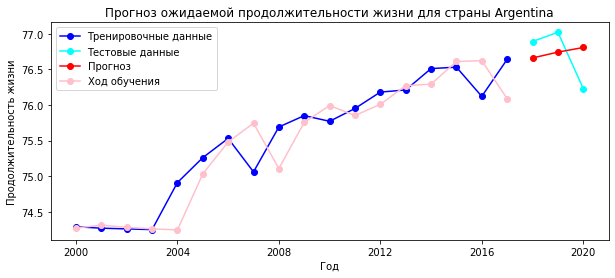

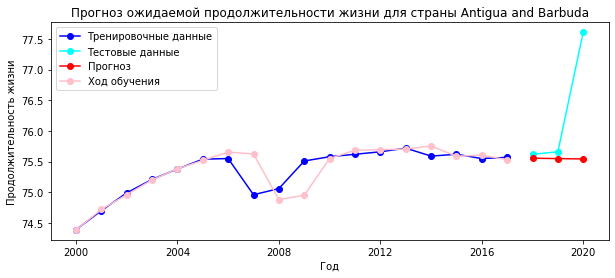

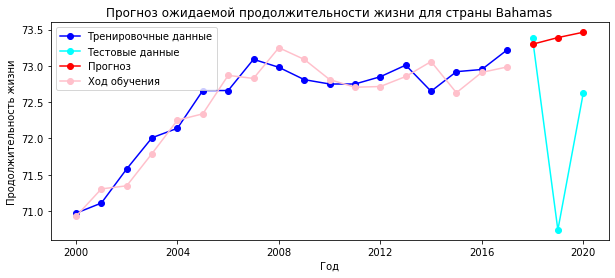

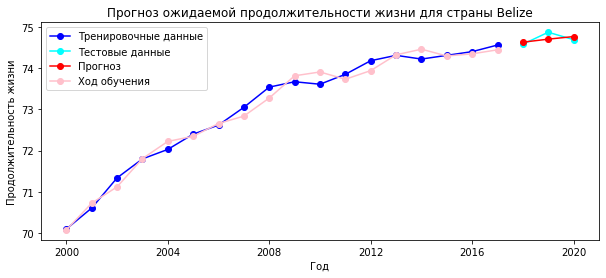

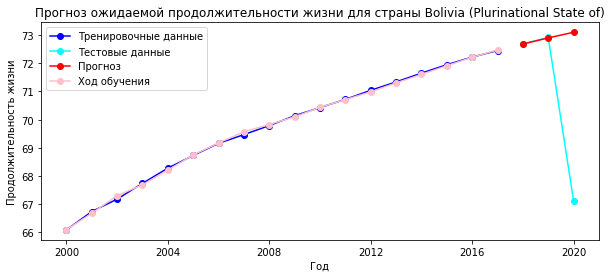

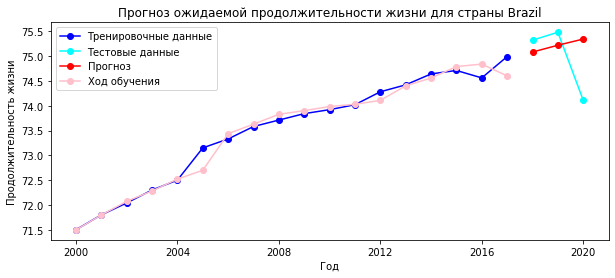

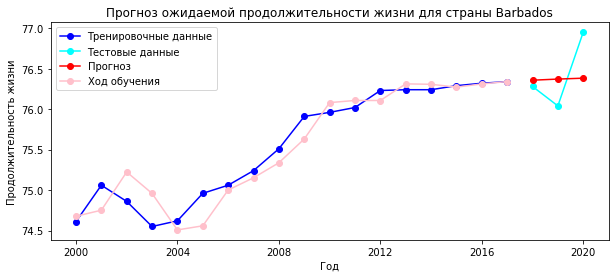

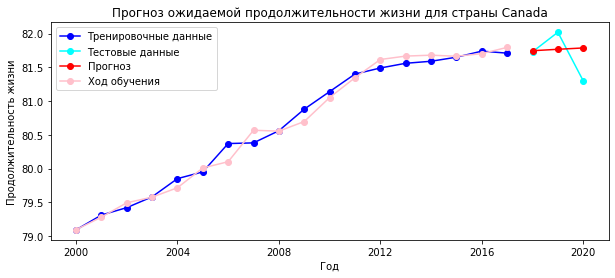

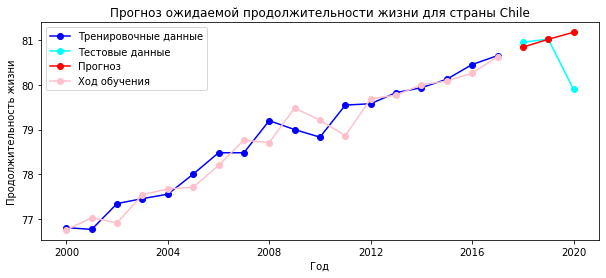

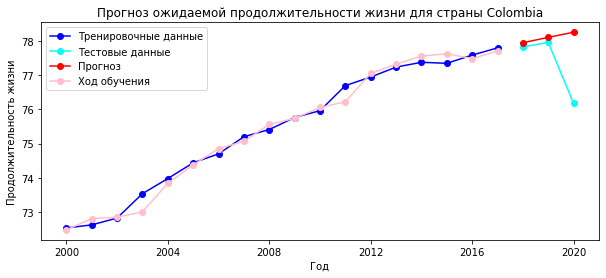

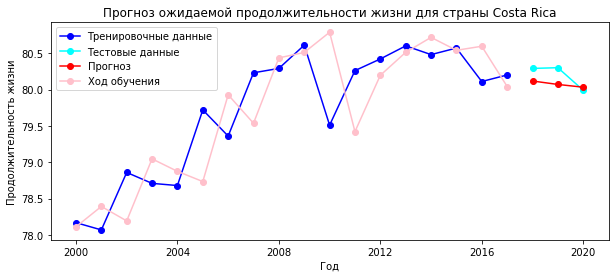

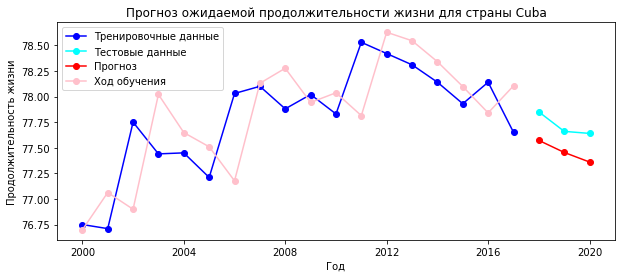

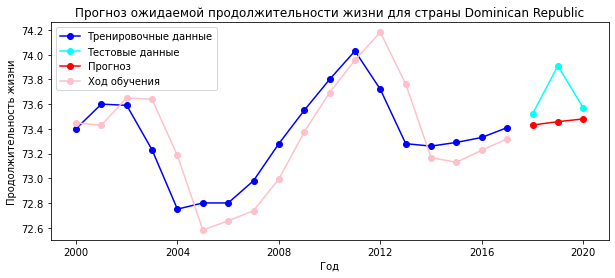

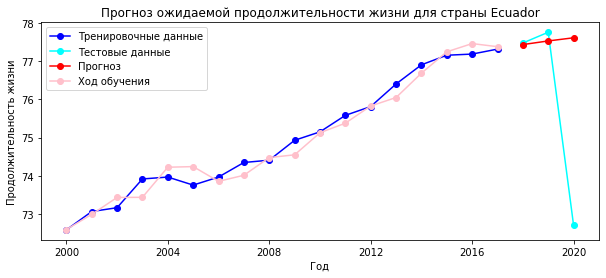

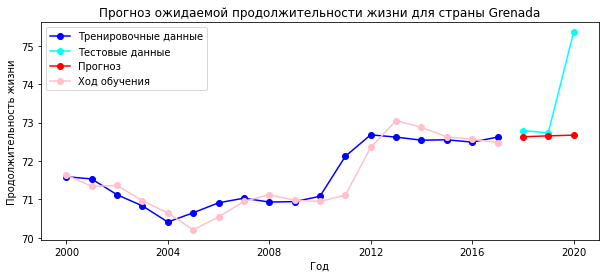

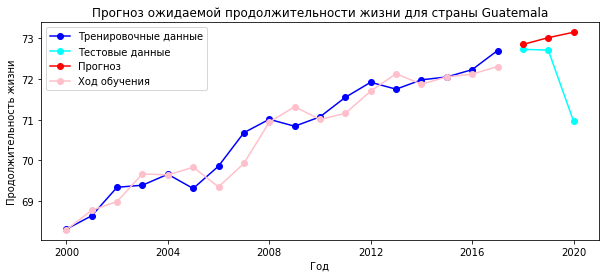

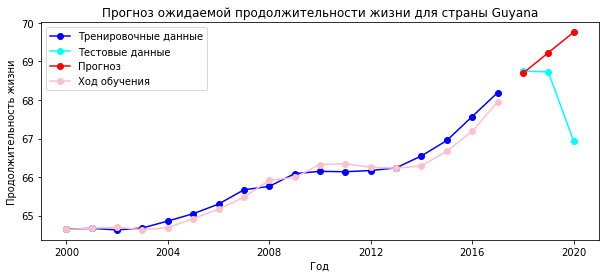

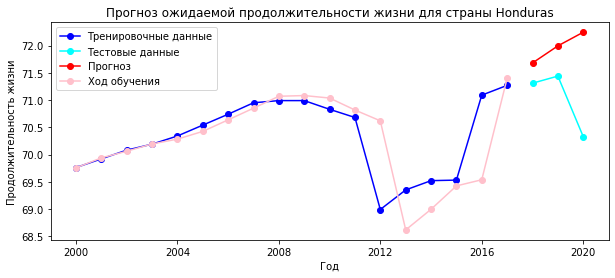

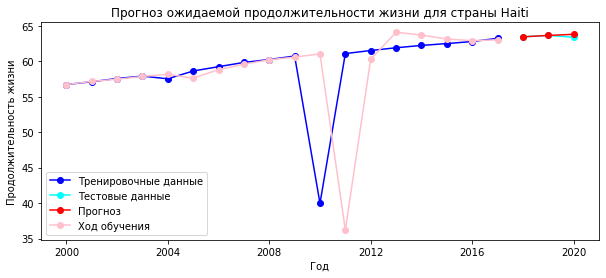

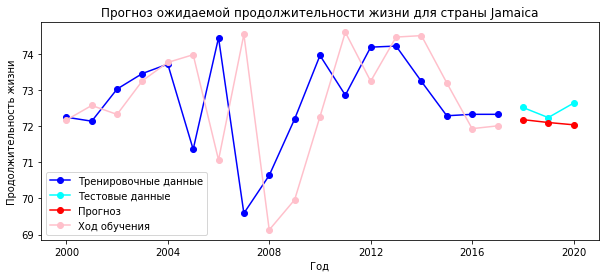

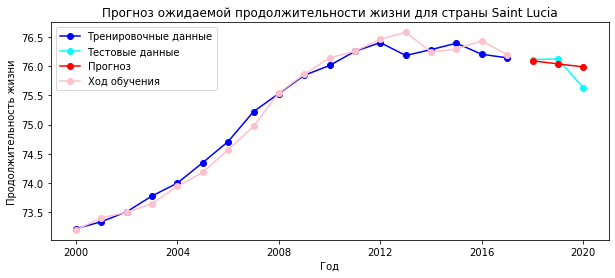

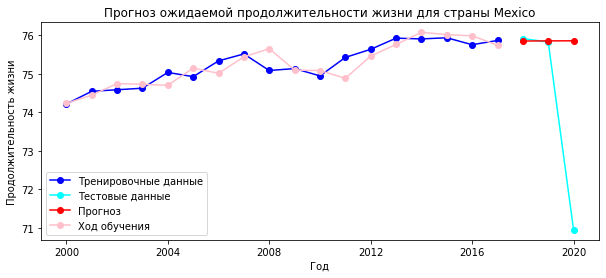

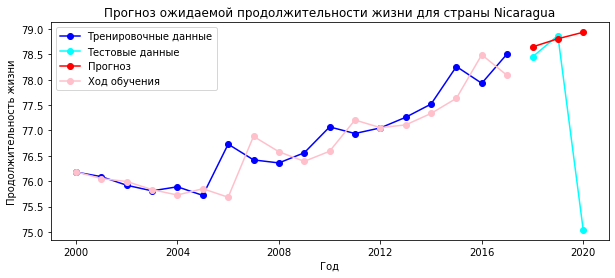

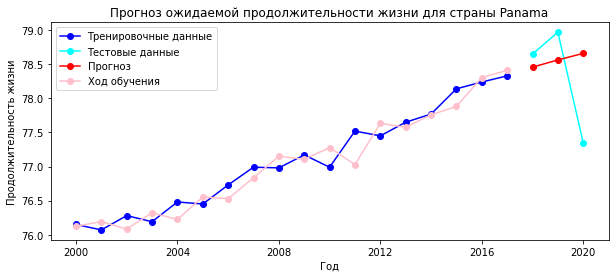

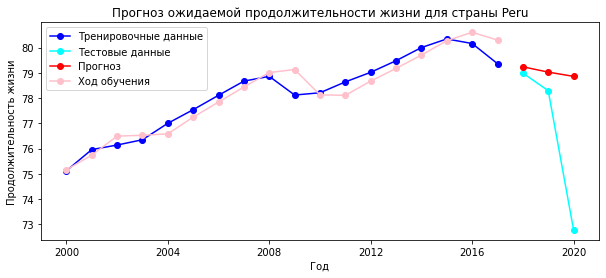

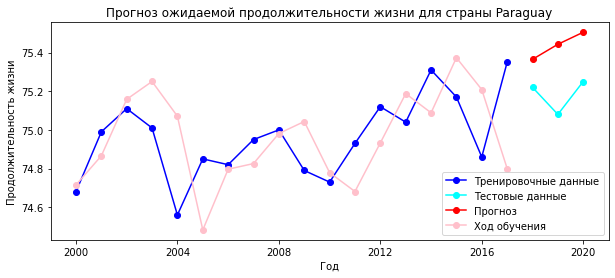

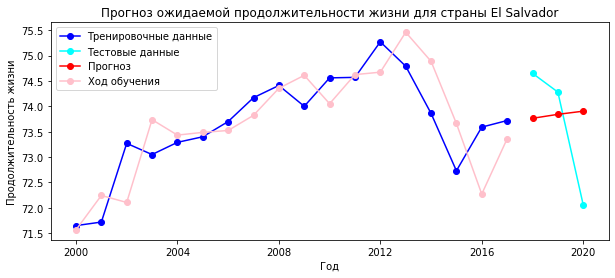

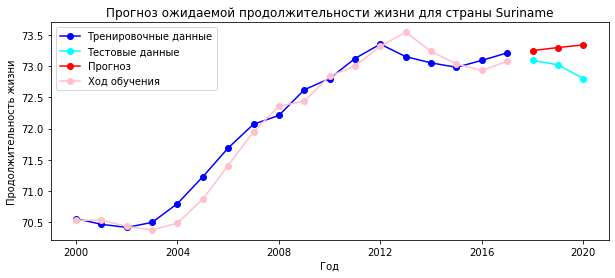

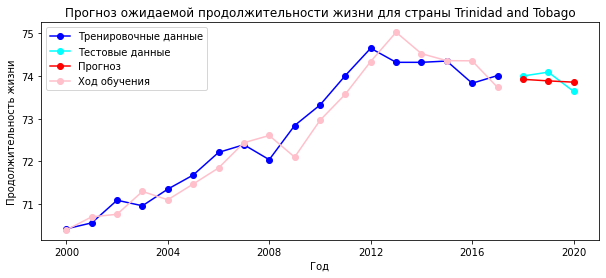

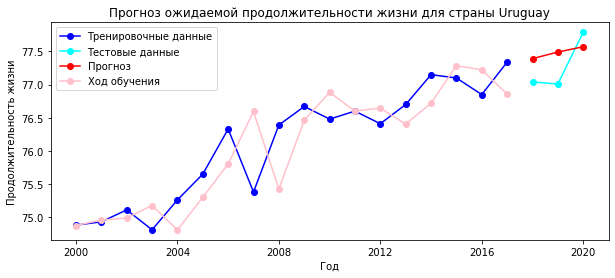

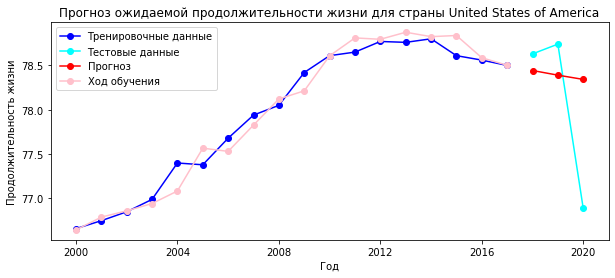

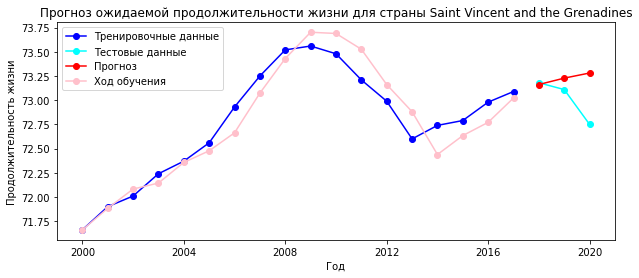

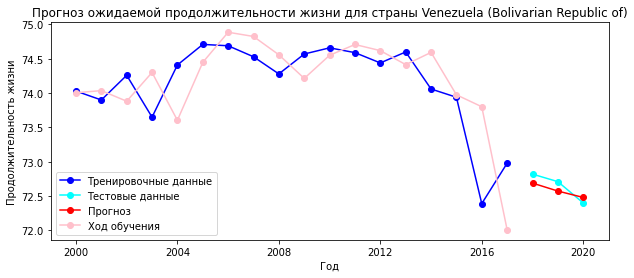

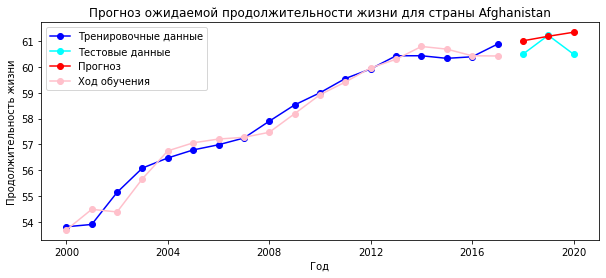

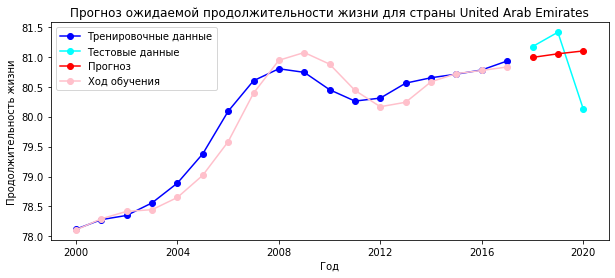

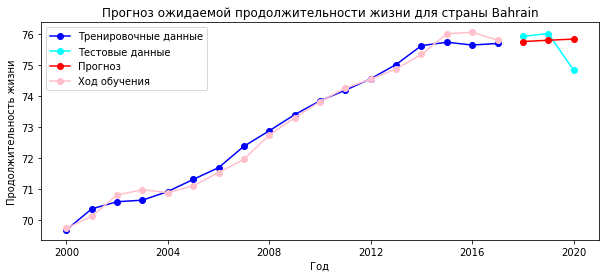

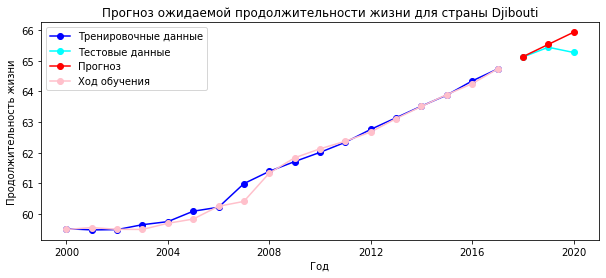

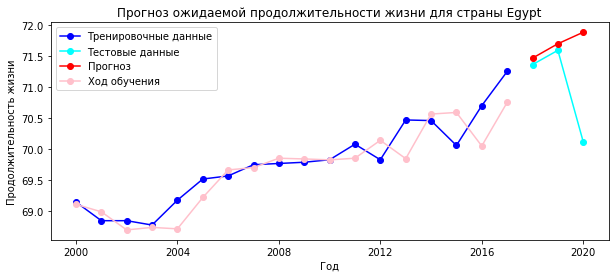

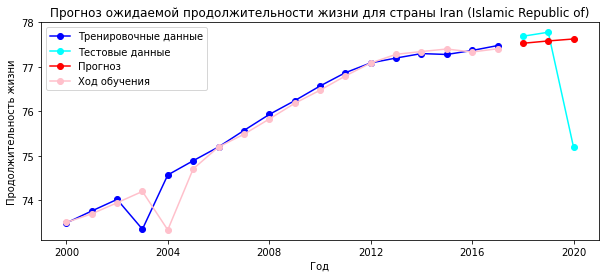

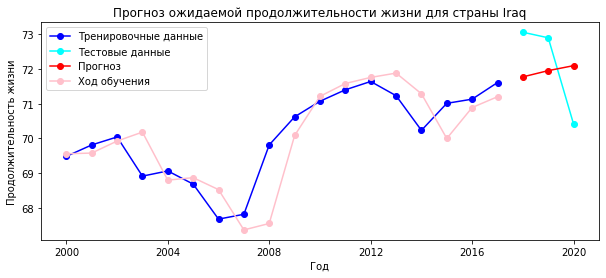

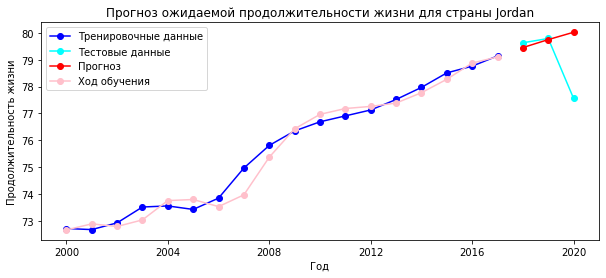

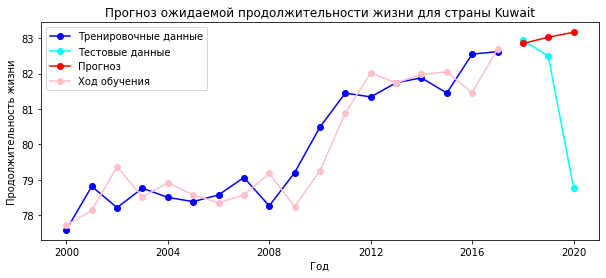

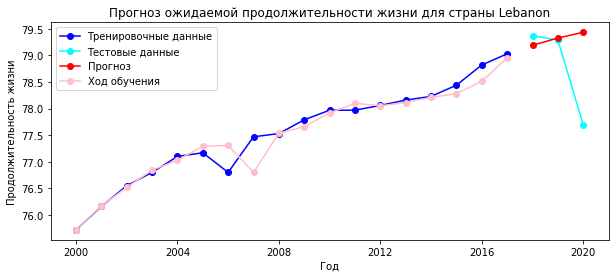

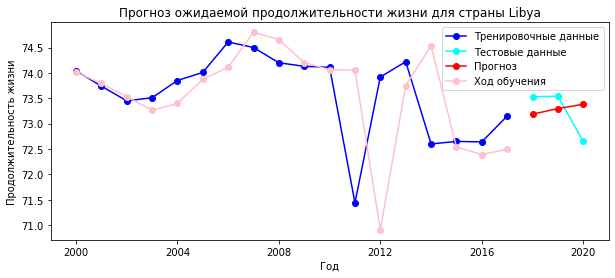

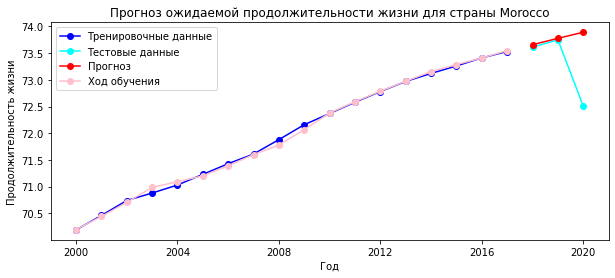

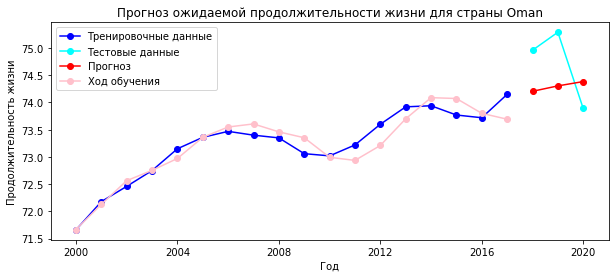

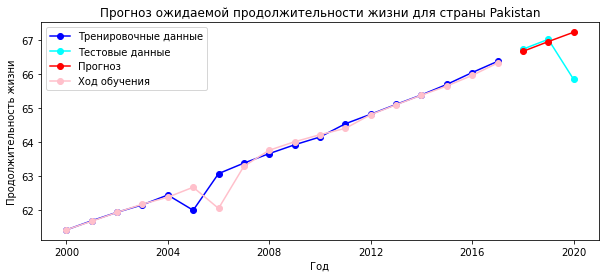

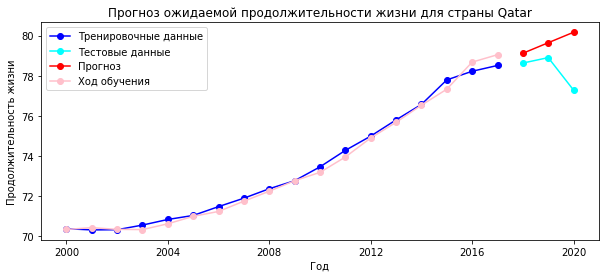

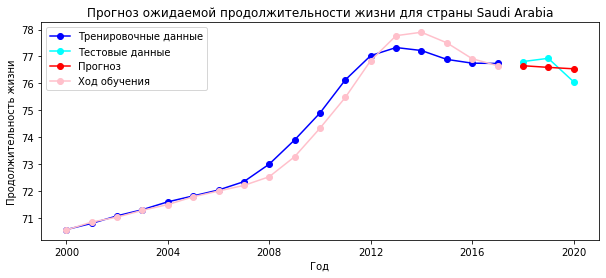

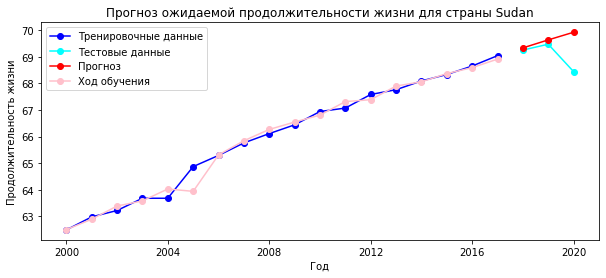

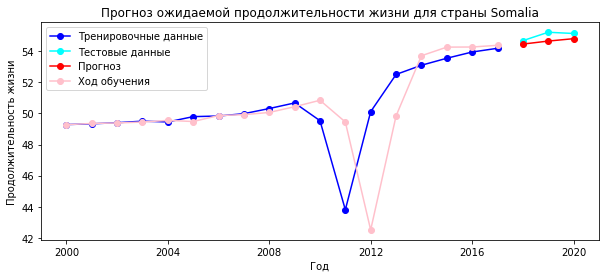

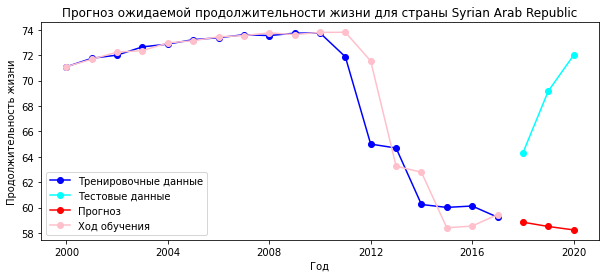

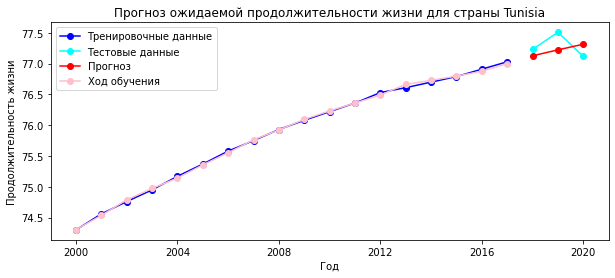

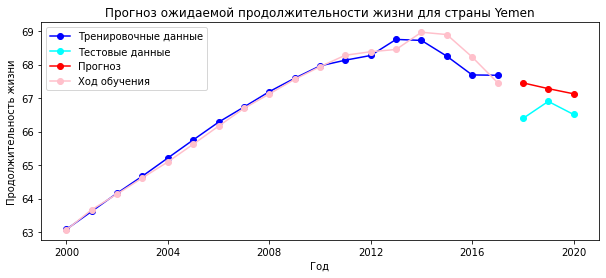

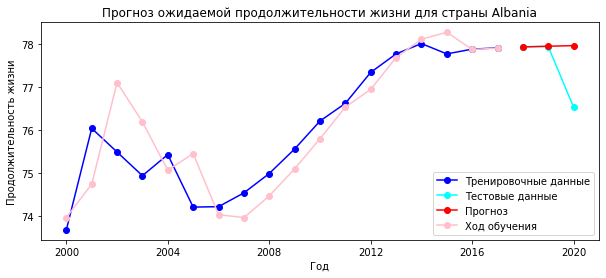

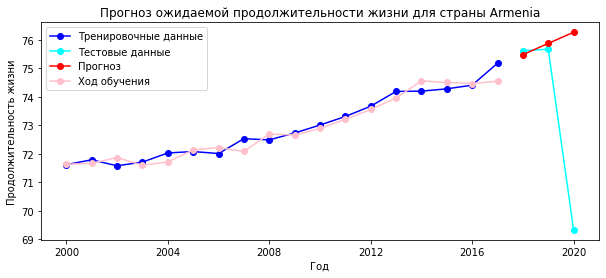

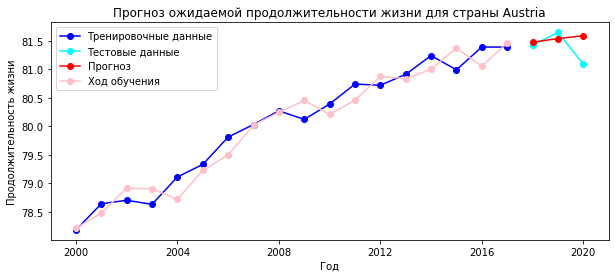

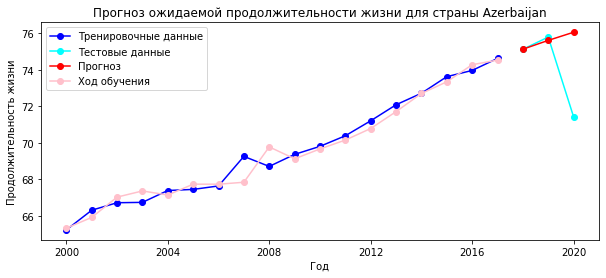

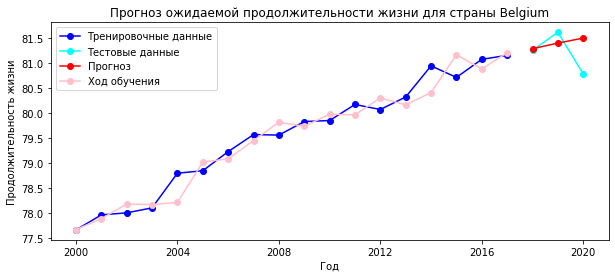

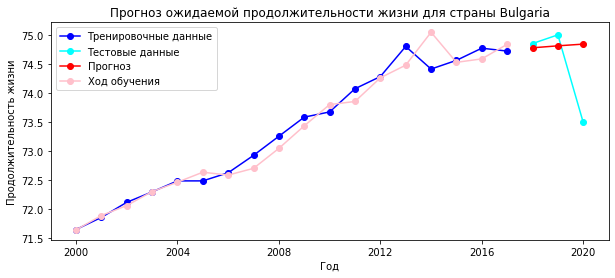

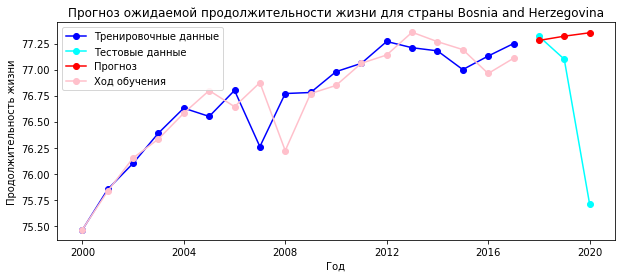

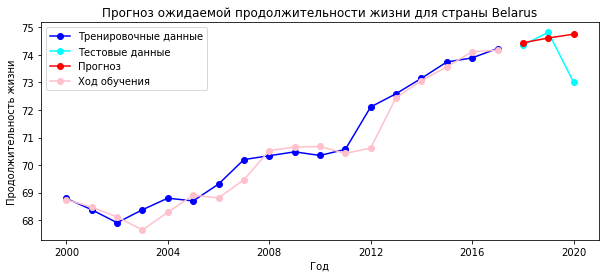

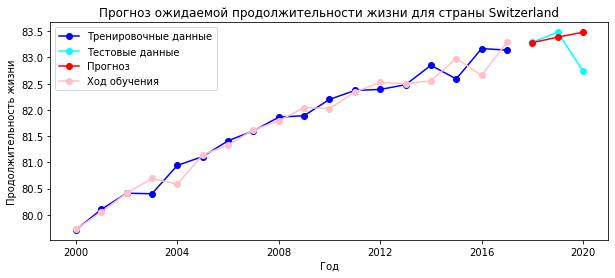

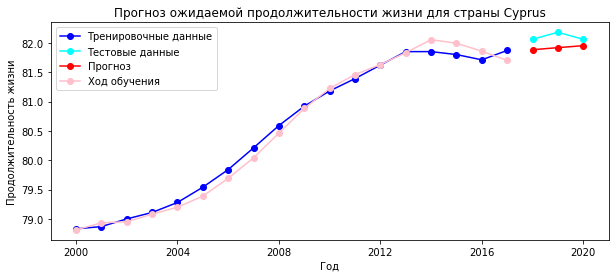

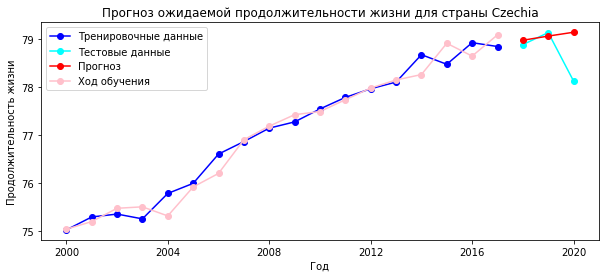

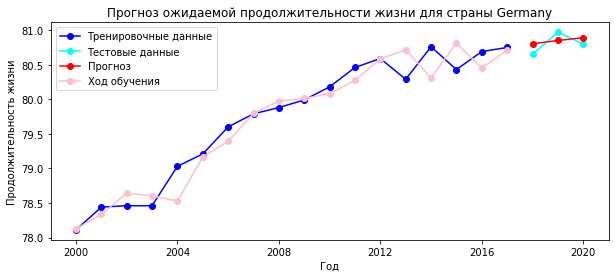

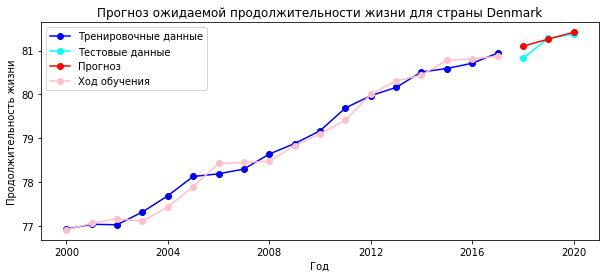

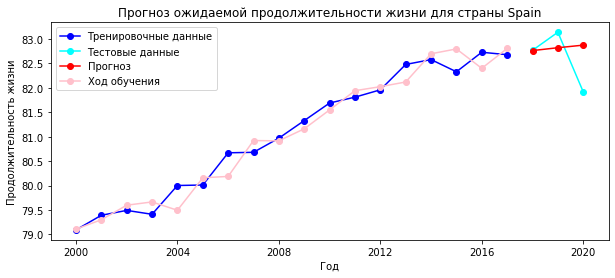

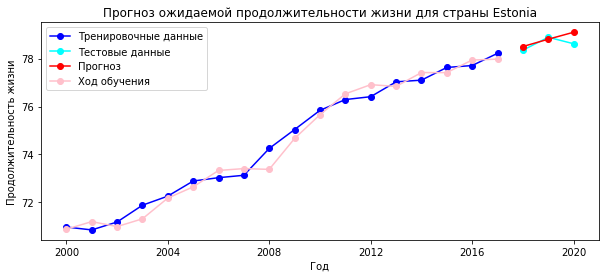

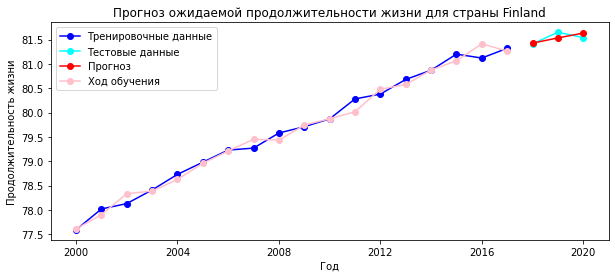

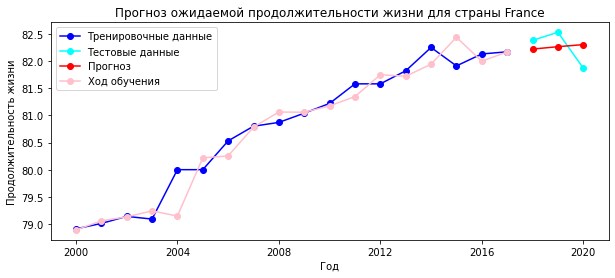

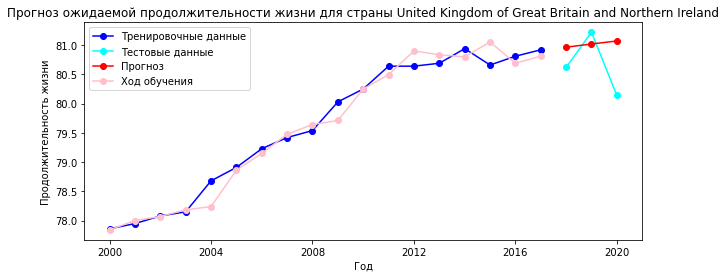

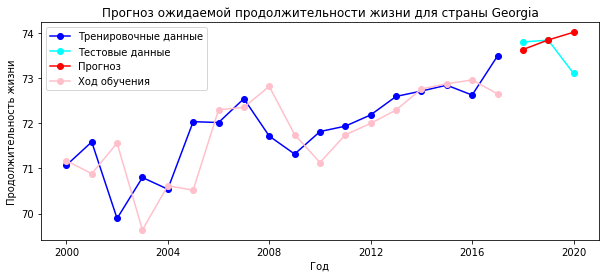

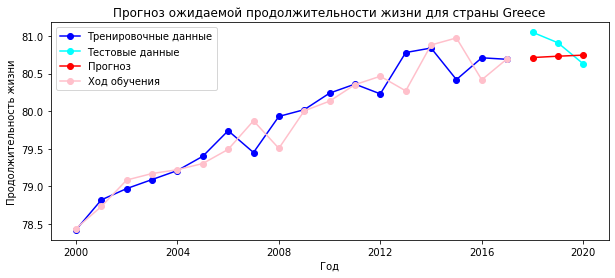

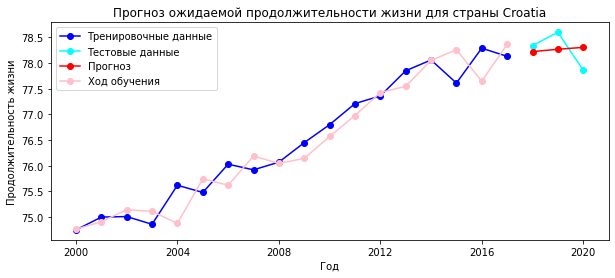

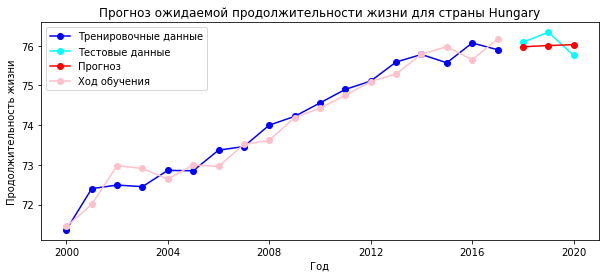

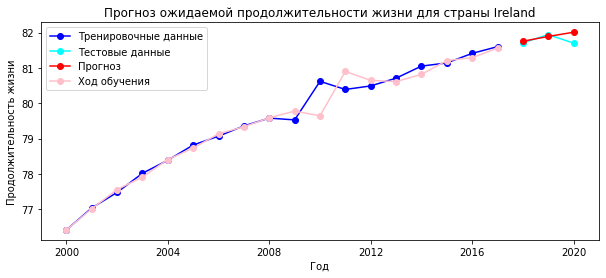

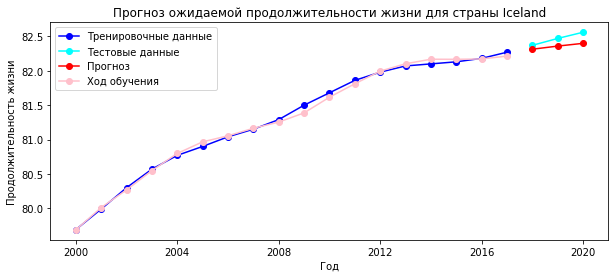

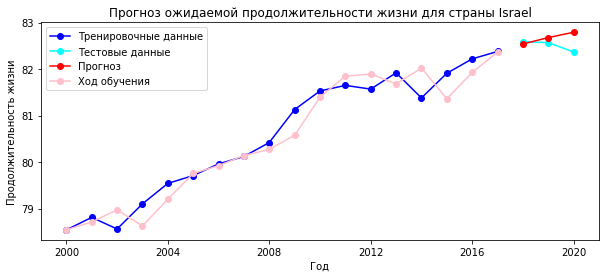

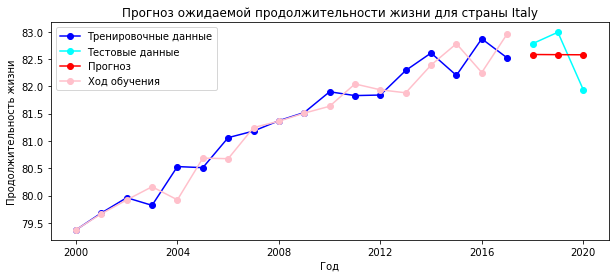

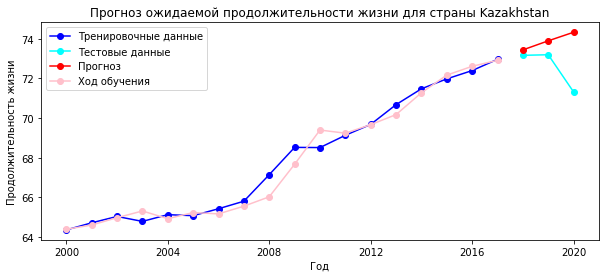

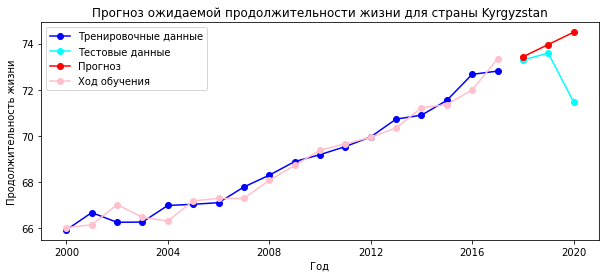

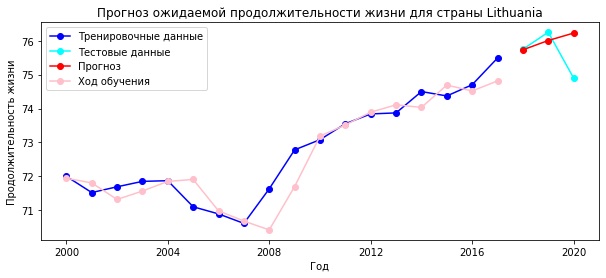

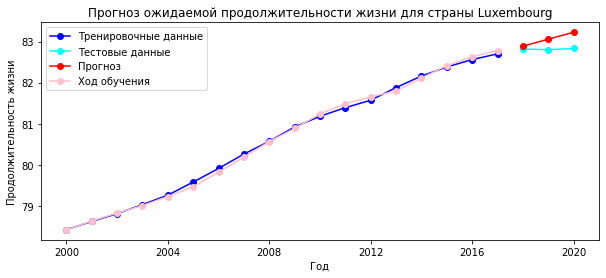

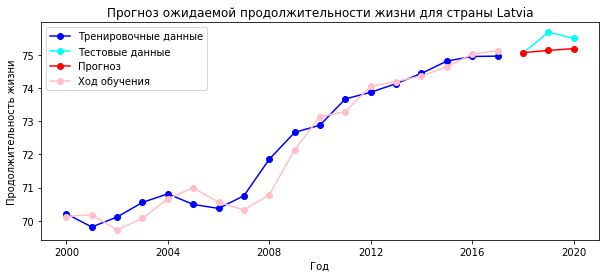

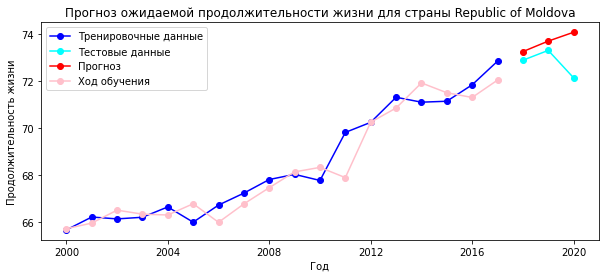

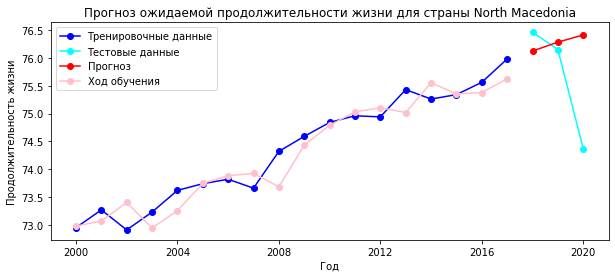

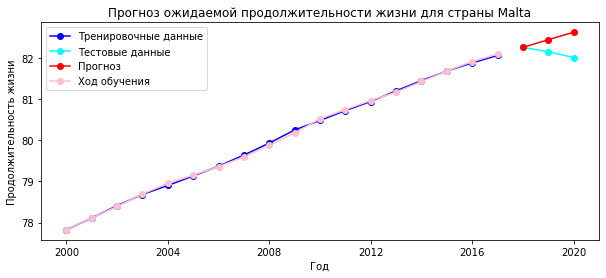

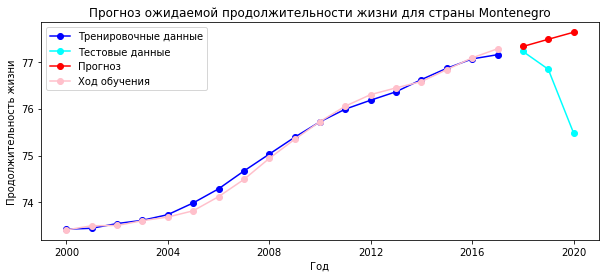

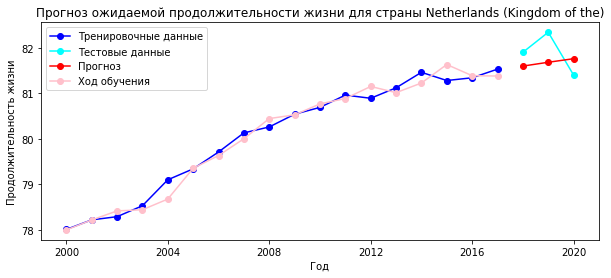

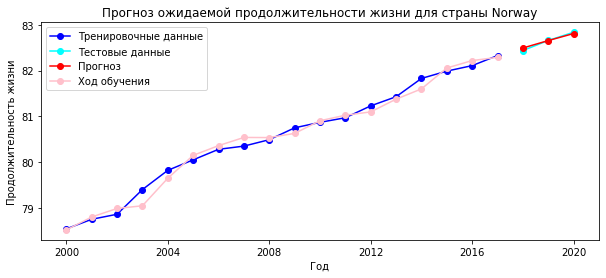

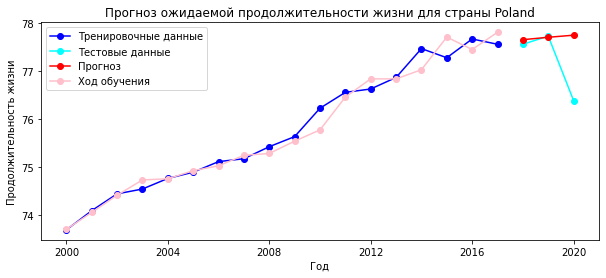

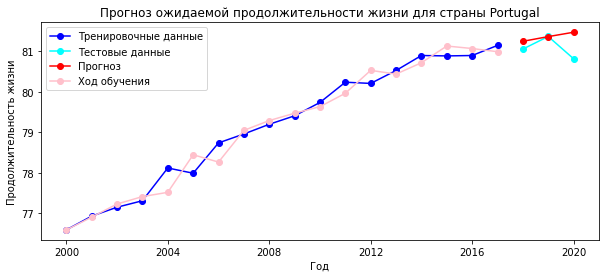

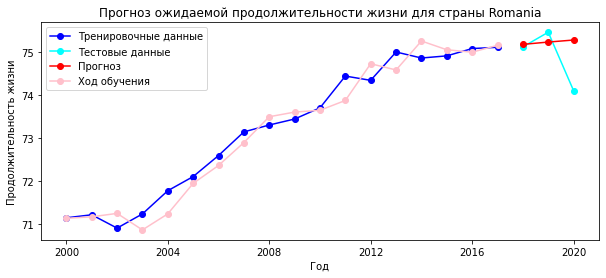

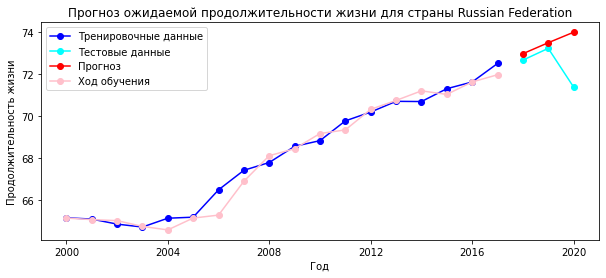

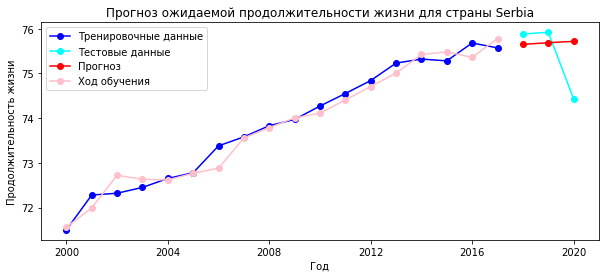

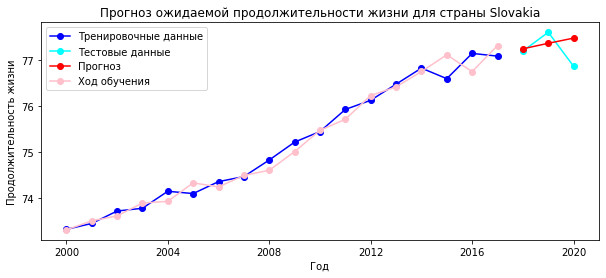

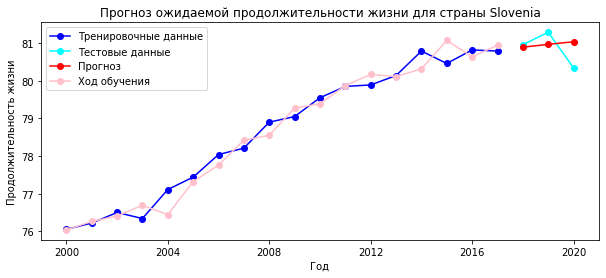

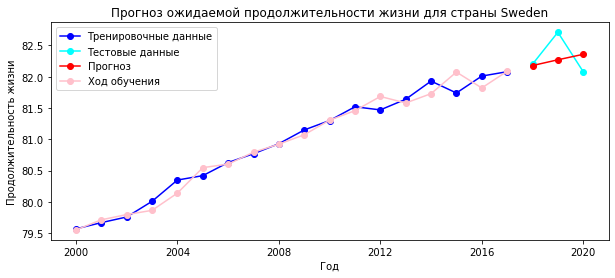

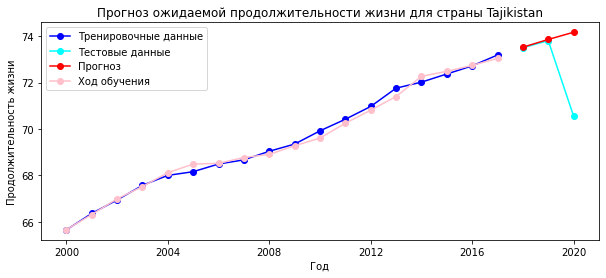

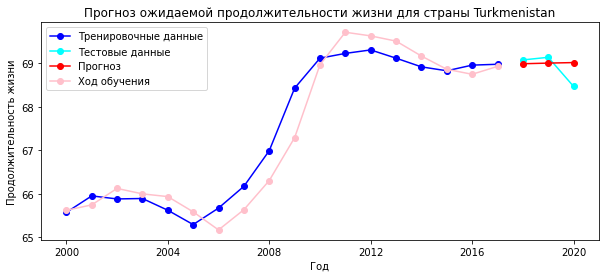

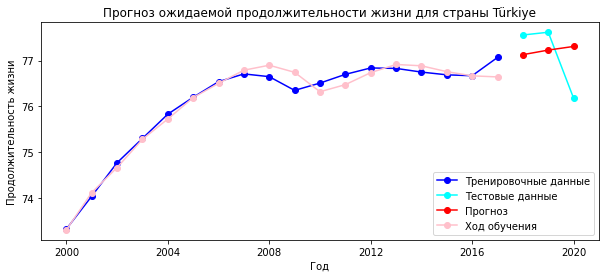

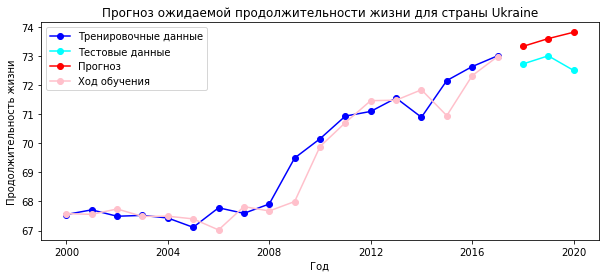

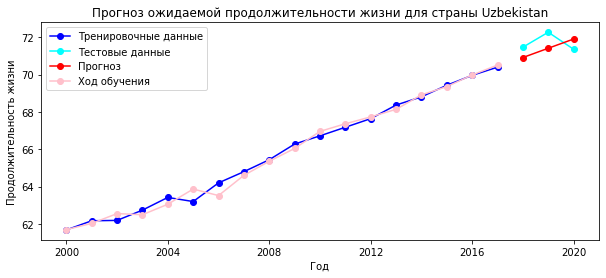

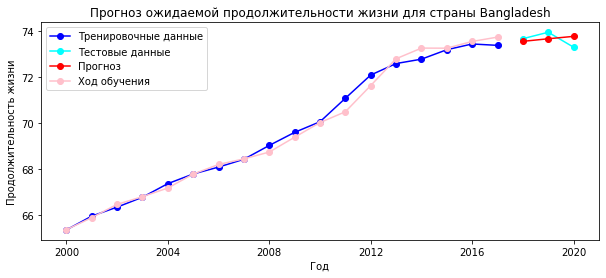

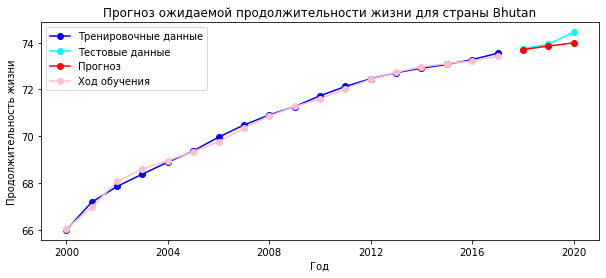

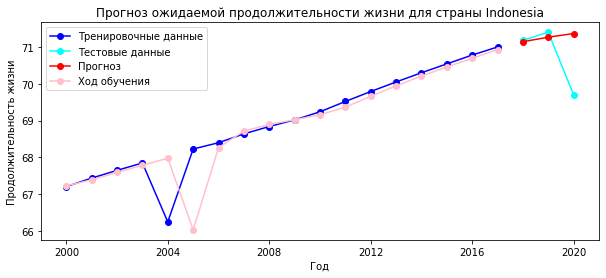

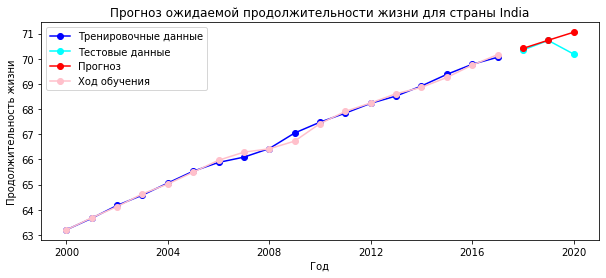

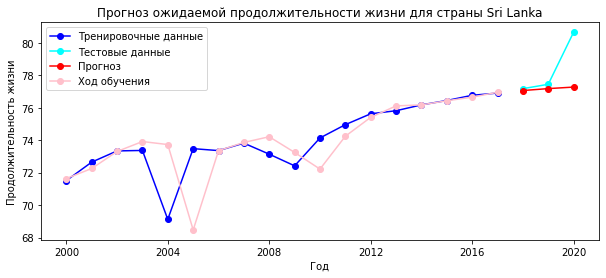

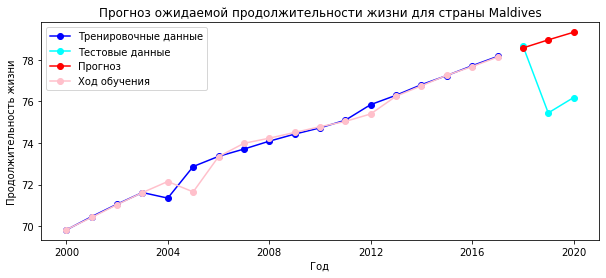

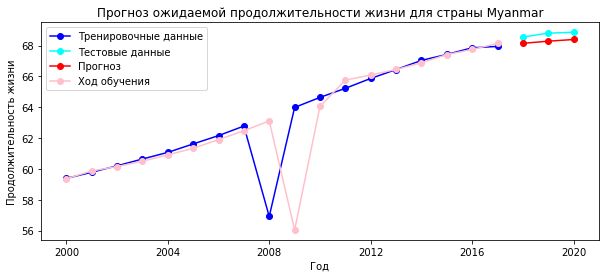

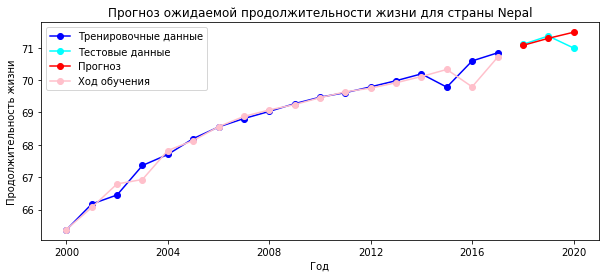

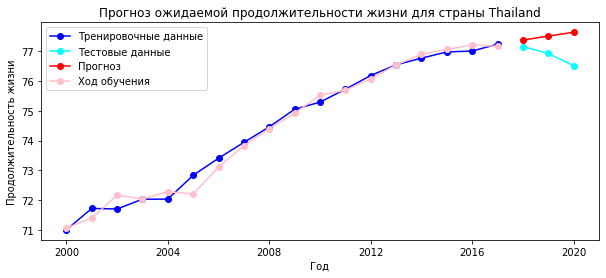

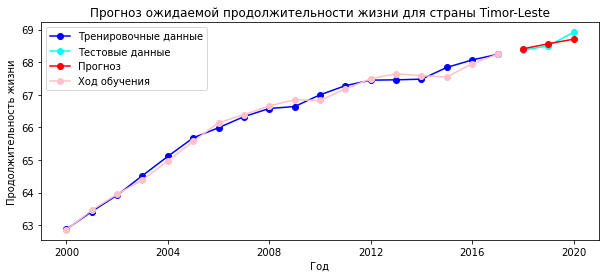

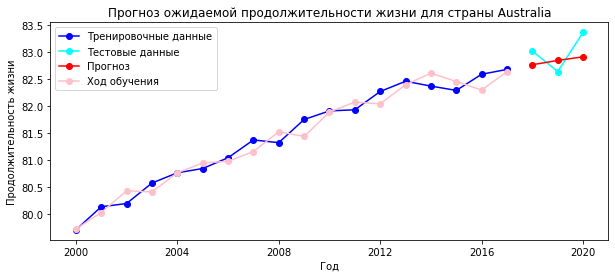

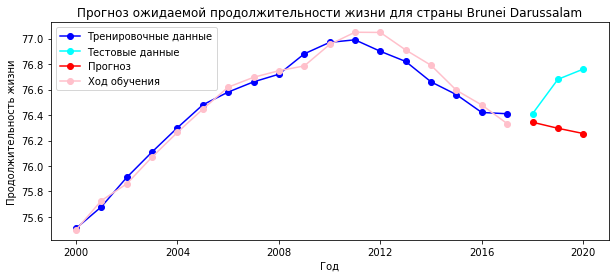

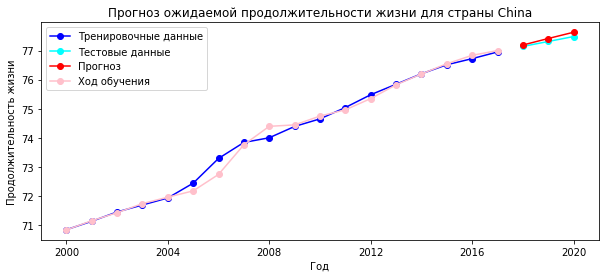

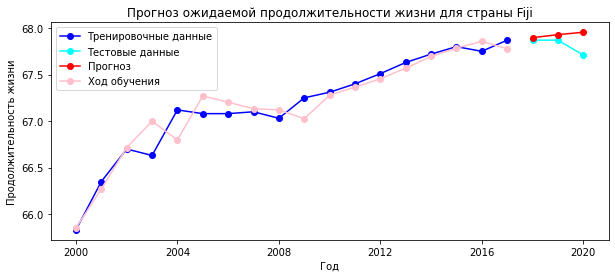

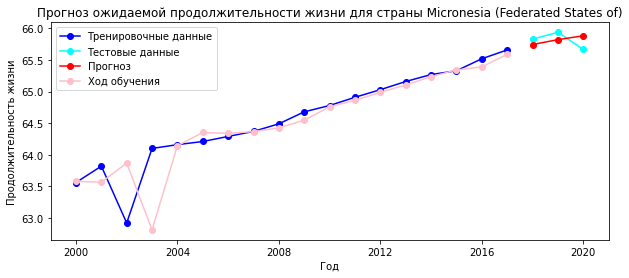

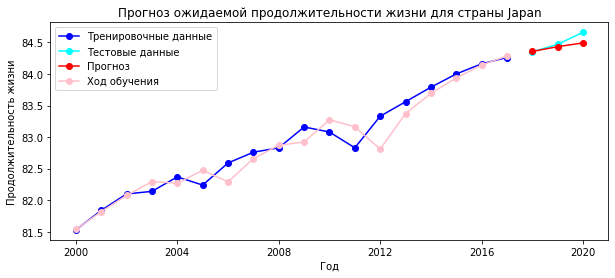

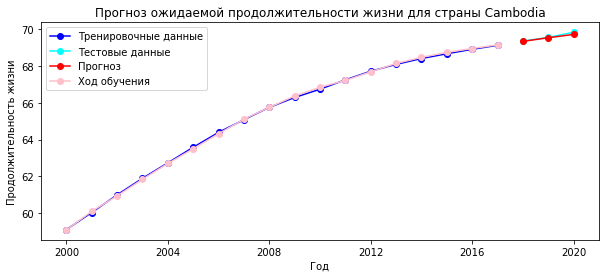

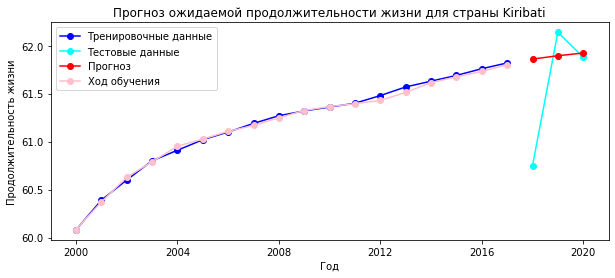

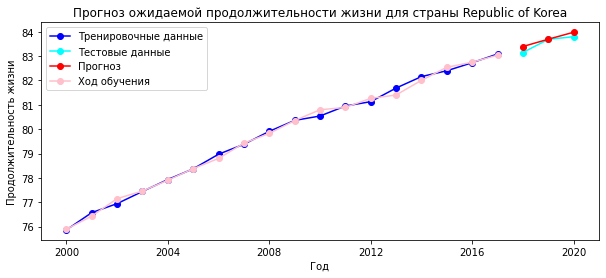

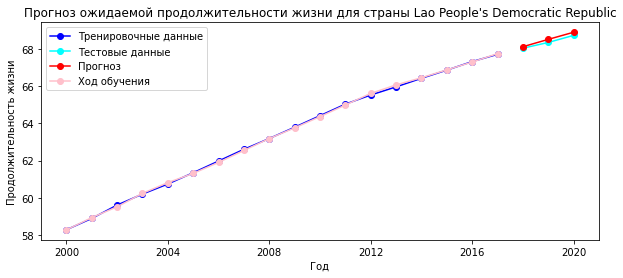

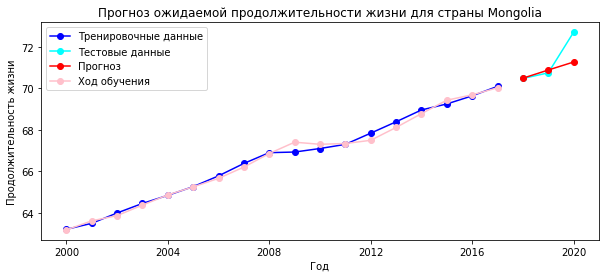

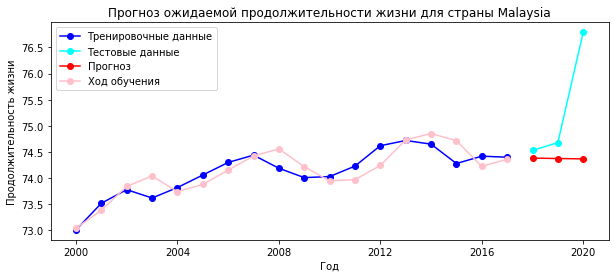

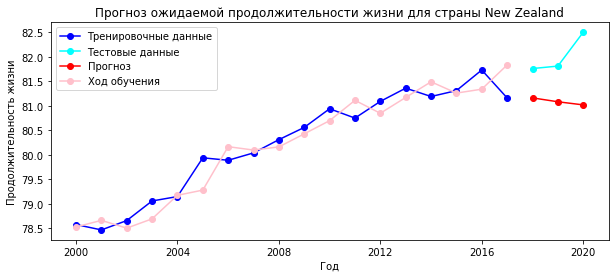

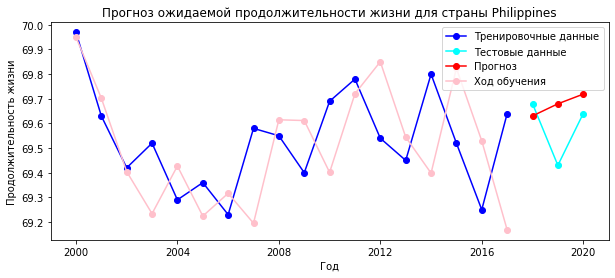

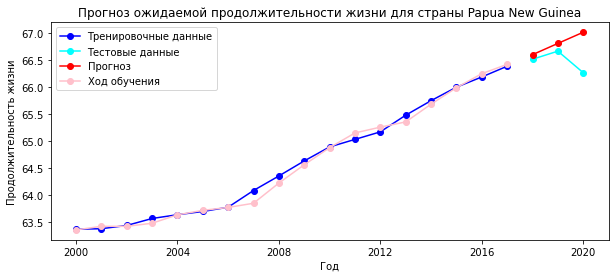

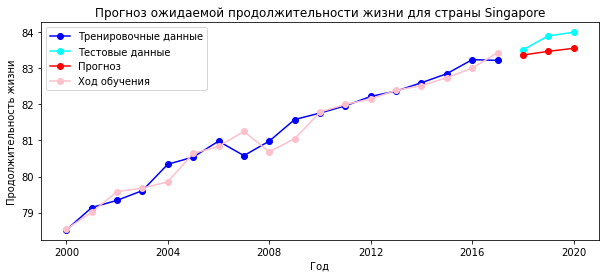

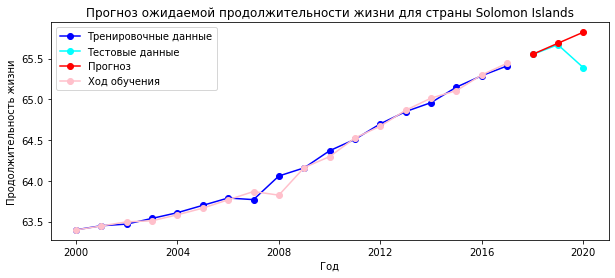

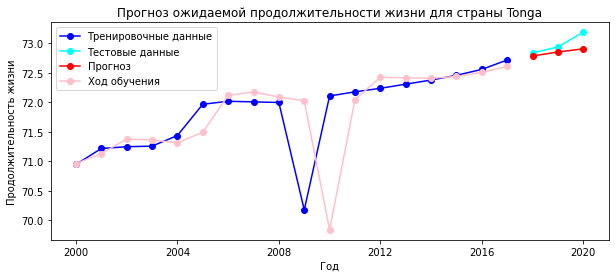

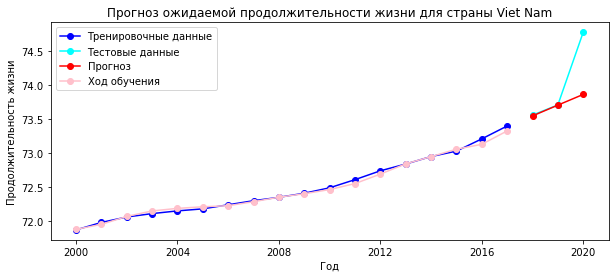

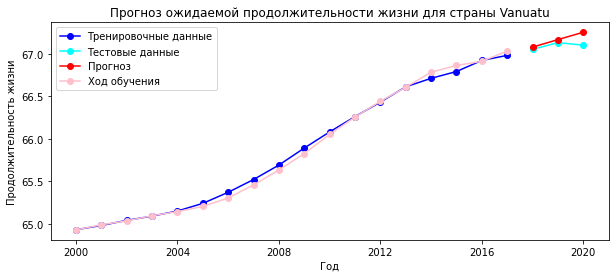

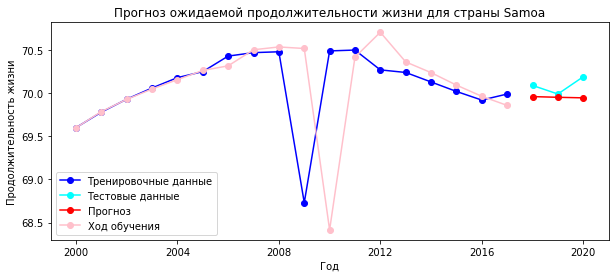

In [ ]:
# Коды всех стран
location_codes = get_location_codes(data_source)

# Для каждой страны построим график
for code in location_codes:
    # Название страны
    location = get_location_by_code(code)
    
    # Временной ряд для тренировочной и тестовой выборок
    time_series_train = get_location_time_series(train_data, code)
    time_series_test = get_location_time_series(test_data, code)
    
    # Временной ряд процесса обучения
    time_series_fitted = get_location_time_series(train_data, code, F.SmoothingLifeExpectancy.value)
    # Временной ряд предсказания сглаженных значений
    time_series_predict = get_location_time_series(test_data, code, F.SmoothingLifeExpectancy.value)
    
    # Выводим график
    display_prediction(
        time_series_train,
        time_series_test,
        time_series_predict,
        location,
        time_series_fitted,
    )

Для многих стран сглаженный прогноз построен довольно точно.

Для ряда стран прогноз сильно расходится с тестовыми данными \
Возможно, это связано с  COVID-19 в 2019-2020 гг.\
Но это сложно было бы спрогнозировать на 3 года вперед.

## Характеристики распределения разности между новым признаком и целевой переменной

Посмотрим на характер распределения ошибок прогноза без модуля.

In [ ]:
error_values = test_data[F.LifeExpectancy.value].values - \
    test_data[F.SmoothingLifeExpectancy.value].values

error_series = pd.Series(error_values)
error_series = error_series.astype(float)

print('Основные характеристики распределения ошибки прогноза')
error_series.describe()

Основные характеристики распределения ошибки прогноза


count    543.000000
mean      -0.190797
std        1.244335
min       -6.936182
25%       -0.360796
50%       -0.035625
75%        0.129321
max       13.764153
dtype: float64

Построим графики распределения значения ошибки без модуля.

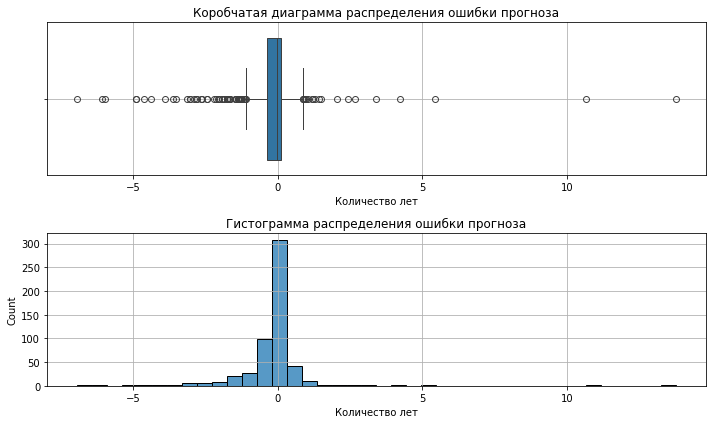

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=.5)

# строим boxplot
sns.boxplot(data=error_series, orient='h', ax=axs[0])
axs[0].set_title('Коробчатая диаграмма распределения ошибки прогноза') 
axs[0].set_xlabel('Количество лет') 
axs[0].grid()

# строим гистограмму
sns.histplot(data=error_series, bins=40, ax=axs[1])
axs[1].set_title('Гистограмма распределения ошибки прогноза')
axs[1].set_xlabel('Количество лет') 
axs[1].grid()


plt.tight_layout()

Размах ошибки от -7 до +14 лет.\
Среднее близко к нулю.

## Корреляция нового признака с целевой переменной

Соединим тренировочную и тестовую таблицы и посмотрим на корреляцию нового признака с целевым.

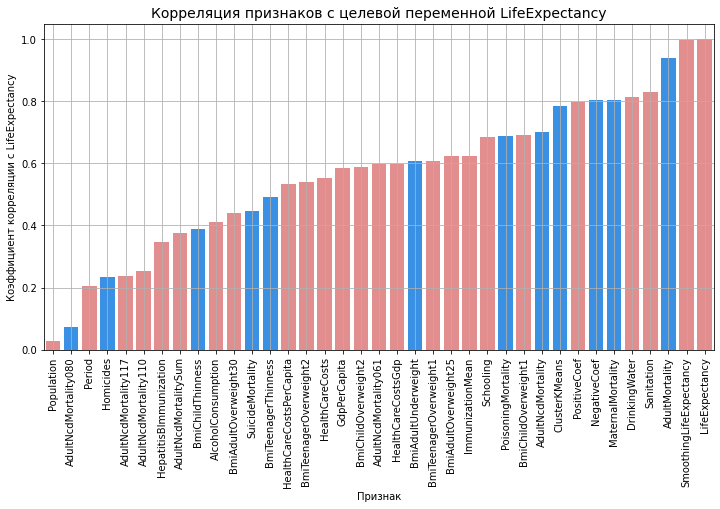

In [14]:
display_corellation_by_target(
    pd.concat([train_data, test_data], ignore_index=True)
)

Корреляция близка к 1, что ожидаемо.